## Проверка результатов А/B-теста

Правила аб-теста:
* пользователь должен быть отнесен строго к одному сегменту

## Описание проекта

Вы — новый аналитик международного интернет-магазина. Ваш предшественник на этой позиции запустил А/B-тест и уволился. Осталось только техническое задание и результаты теста. Техническое задание:

- Наименование теста: `recommender_system_test`;
- Группы: А (контрольная), B (новая платежная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
- Ожидаемое количество участников теста: 6000.

Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

### Данные

- `ab_project_marketing_events.csv` - календарь маркетинговых событий на 2020 год.
- `final_ab_new_users.csv` - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
- `final_ab_events.csv` - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- `final_ab_participants.csv` - таблица участников тестов.

Структура файла `ab_project_marketing_events.csv`:

- `name` - название маркетингового события;
- `regions` - регионы, в которых будет проводиться рекламная кампания;
- `start_dt` - дата начала кампании;
- `finish_dt` - дата завершения кампании.

Структура файла `final_ab_new_users.csv`:

- `user_id` - уникальный идентификатор пользователя;
- `first_date` - дата регистрации;
- `region` - регион, к которому относится пользователь;
- `device` - устройство, с которого происходила регистрация.

Структура файла `final_ab_events.csv`:

- `user_id` - уникальный идентификатор пользователя;
- `event_dt` - дата и время покупки;
- `event_name` - наименование типа события;
- `details` - дополнительные данные события. Например, для событий покупок (`purchase`) в этом поле хранится стоимость покупки (USD);

Структура файла `final_ab_participants.csv`:

- `user_id` - уникальный идентификатор пользователя;
- `ab_test` - название теста;
- `group` - группа, в которой находился пользователь в рамках теста.

### Как выполнить задание

- Опишите цели исследования.
- Исследуйте данные:
    - Требуется ли преобразование типов?
    - Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?
- Оцените корректность проведения теста. Обратите внимание на:
    - Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
    - Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.
- Проведите исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
- Проведите оценку результатов A/B-тестирования:
    - Что можно сказать про результаты A/B-тестирования?
    - Проверьте статистическую разницу долей z-критерием
- Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import re
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power
import seaborn as sns
import matplotlib.pyplot as plt

## Опишите цели исследования:
Тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.


Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
* конверсии в просмотр карточек товаров — событие `product_page`,
* просмотры корзины — `product_cart`,
* покупки — `purchase`.


Ожидаемое количество участников теста: 6000.

In [2]:
df_calendar_events_2020 = pd.read_csv('ab_project_marketing_events.csv') # - календарь маркетинговых событий на 2020 год.
df_users_7_21_decamber = pd.read_csv('final_ab_new_users.csv') # - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
df_events_7_decamber_4_January = pd.read_csv('final_ab_events.csv') # - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
df_participants = pd.read_csv('final_ab_participants.csv') # - таблица участников тестов.

## Исследуйте данные:

In [3]:
def pack(func, **kwargs):
    def inner(**kwargs):
        func(**kwargs)
    return inner

@pack
def base_analysis(**kwargs):
    for name_df, df in kwargs.items():
        print(f'=========Базовый анализ датафрейма {name_df}=========')
        print('')
        display(df)
        print(f'{df.info()}')
        print(f'{df.describe()}')
        print(f'количество дубликатов равно {df.duplicated().sum()}')
        print('')
        print(f'количество пропусков равно\n {df.isnull().sum()}')
        print('===========================================================')
        print('')


base_analysis(df_calendar_events_2020=df_calendar_events_2020,
                df_users_7_21_decamber=df_users_7_21_decamber,
                df_events_7_decamber_4_January=df_events_7_decamber_4_January,
                df_participants=df_participants)

=========Базовый анализ датафрейма df_calendar_events_2020=========



name                   regions    start_dt  \
0           Christmas&New Year Promo             EU, N.America  2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2             St. Patric's Day Promo             EU, N.America  2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4                  4th of July Promo                 N.America  2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America  2020-11-26   
6             Chinese New Year Promo                      APAC  2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC  2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC  2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS  2020-05-09   
10         CIS New Year Gift Lottery                       CIS  2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC  2020-06-25   
12           Single's Day Gift Promo                      APAC  2020-11-11   
13             Chinese Moon Festival                      APAC  2020-10-01   

     finish_dt  
0   2021-01-03  
1   2020-02-16  
2   2020-03-19  
3   2020-04-19  
4   2020-07-11  
5   2020-12-01  
6   2020-02-07  
7   2020-05-03  
8   2020-03-10  
9   2020-05-11  
10  2021-01-07  
11  2020-07-01  
12  2020-11-12  
13  2020-10-07

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
                            name regions    start_dt   finish_dt
count                         14      14          14          14
unique                        14       6          14          14
top     Christmas&New Year Promo    APAC  2020-12-25  2021-01-03
freq                           1       4           1           1
количество дубликатов равно 0

количество пропусков равно
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

=========Базовый анализ датафрейма df_users_7_21_decamber=========



user_id  first_date     region   device
0      D72A72121175D8BE  2020-12-07         EU       PC
1      F1C668619DFE6E65  2020-12-07  N.America  Android
2      2E1BF1D4C37EA01F  2020-12-07         EU       PC
3      50734A22C0C63768  2020-12-07         EU   iPhone
4      E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
...                 ...         ...        ...      ...
61728  1DB53B933257165D  2020-12-20         EU  Android
61729  538643EB4527ED03  2020-12-20         EU      Mac
61730  7ADEE837D5D8CBBD  2020-12-20         EU       PC
61731  1C7D23927835213F  2020-12-20         EU   iPhone
61732  8F04273BB2860229  2020-12-20         EU  Android

[61733 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
                 user_id  first_date region   device
count              61733       61733  61733    61733
unique             61733          17      4        4
top     D72A72121175D8BE  2020-12-21     EU  Android
freq                   1        6290  46270    27520
количество дубликатов равно 0

количество пропусков равно
 user_id       0
first_date    0
region        0
device        0
dtype: int64

=========Базовый анализ датафрейма df_events_7_decamber_4_January=========



user_id             event_dt event_name  details
0       E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1       7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2       9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3       96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4       1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99
...                  ...                  ...        ...      ...
440312  245E85F65C358E08  2020-12-30 19:35:55      login      NaN
440313  9385A108F5A0A7A7  2020-12-30 10:54:15      login      NaN
440314  DB650B7559AC6EAC  2020-12-30 10:59:09      login      NaN
440315  F80C9BDDEA02E53C  2020-12-30 09:53:39      login      NaN
440316  7AEC61159B672CC5  2020-12-30 11:36:13      login      NaN

[440317 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
            details
count  62740.000000
mean      23.877631
std       72.180465
min        4.990000
25%        4.990000
50%        4.990000
75%        9.990000
max      499.990000
количество дубликатов равно 0

количество пропусков равно
 user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

=========Базовый анализ датафрейма df_participants=========



user_id group                  ab_test
0      D1ABA3E2887B6A73     A  recommender_system_test
1      A7A3664BD6242119     A  recommender_system_test
2      DABC14FDDFADD29E     A  recommender_system_test
3      04988C5DF189632E     A  recommender_system_test
4      482F14783456D21B     B  recommender_system_test
...                 ...   ...                      ...
18263  1D302F8688B91781     B        interface_eu_test
18264  3DE51B726983B657     A        interface_eu_test
18265  F501F79D332BE86C     A        interface_eu_test
18266  63FBE257B05F2245     A        interface_eu_test
18267  79F9ABFB029CF724     B        interface_eu_test

[18268 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
                 user_id  group            ab_test
count              18268  18268              18268
unique             16666      2                  2
top     0FDFDA0B2DEC2D91      A  interface_eu_test
freq                   2   9655              11567
количество дубликатов равно 0

количество пропусков равно
 user_id    0
group      0
ab_test    0
dtype: int64



In [4]:
def convert_to_datetime(**kwargs):
    for name_df, df in kwargs.items():
        print('\n\n')
        print(f'=========обработка датафрейма {name_df}=========')
        for col_name, col in df.iteritems():
            if df[col_name].dtype == 'object' and df[col_name].str.findall(r'[0-9]{2,4}-[0-9]{2}-[0-9]{2}').any():
                try:
                    df[col_name] = pd.to_datetime(df[col_name], "%Y-%m-%d %H:%M:%S")
                except AssertionError:
                    df[col_name] = pd.to_datetime(df[col_name])
                print(f'{df.info()}')
                    
                
convert_to_datetime(df_calendar_events_2020=df_calendar_events_2020,
                df_users_7_21_decamber=df_users_7_21_decamber,
                df_events_7_decamber_4_January=df_events_7_decamber_4_January,
                df_participants=df_participants)
# df[col_name] = pd.to_datetime(df[col_name], "%Y-%m-%d %H:%M:%S")




=========обработка датафрейма df_calendar_events_2020=========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 576.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None



=========обработка датафр

### Вывод:
Требуется ли преобразование типов?
* Преобразование типов требуется. Есть столбцы с датами, которые нам потребуется преобразовать из строчого типа "object" в тип "date" и "datetime".

Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?
* Дубликатов взятых по целым строкам нет, но есть пропущенные значения в фрейме данных "df_events_7_decamber_4_January" и их природа вещественная(т.е. это столбец вещественных чисел, где пропущенные значение  - это отсутствие того, сколько покупатель отдал денег(USD) за покупку)

## Оцените корректность проведения теста. Обратите внимание на:
1. Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
2. Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
3. Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.


#### 1. Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания:

- [x] Наименование теста: `recommender_system_test`;
- [x] Группы: А (контрольная), B (новая платежная воронка);
- [x] Дата запуска: 2020-12-07;
- [x] Дата остановки набора новых пользователей: 2020-12-21;
- [] Дата остановки: 2021-01-04;
- [x] Аудитория: 15% новых пользователей из региона EU;
- [x] Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- [x] Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
- [x] Ожидаемое количество участников теста: 6000.

Наименование теста: recommender_system_test?

In [5]:
df_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Группы: А (контрольная), B (новая платежная воронка)?

In [6]:
print('группы в выборке данных: ', df_participants[['ab_test', 'group']].groupby('ab_test').agg(set))

группы в выборке данных:                            group
ab_test                        
interface_eu_test        {B, A}
recommender_system_test  {B, A}


* Дата запуска: 2020-12-07?
* Дата остановки набора новых пользователей: 2020-12-21?
* Дата остановки: 2021-01-04?

In [7]:
print(f"Начальная дата набора пользователей {df_users_7_21_decamber['first_date'].min()} и конечная дата набора пользователей {df_users_7_21_decamber['first_date'].max()}") 

Начальная дата набора пользователей 2020-12-07 00:00:00 и конечная дата набора пользователей 2020-12-23 00:00:00


In [8]:
print(f"Начальная дата и время взаимодействия пользователей с интернет-магазином {df_events_7_decamber_4_January['event_dt'].min()} и конечная дата и время взаимодействия пользователей с интернет-магазином(дата и время окончания а/б-теста) {df_events_7_decamber_4_January['event_dt'].max()}") 

Начальная дата и время взаимодействия пользователей с интернет-магазином 2020-12-07 00:00:33 и конечная дата и время взаимодействия пользователей с интернет-магазином(дата и время окончания а/б-теста) 2020-12-30 23:36:33


Дата запуска в тех.задании указана правильно.

Дата остановки набора новых пользователей отличается на два дня и равна 2020-12-23 00:00:00.

Дата остановки аб-теста отличается от тех.задания и равно 2020-12-30 23:36:33

In [9]:
start_user_time = df_users_7_21_decamber['first_date'].min()
stop_user_time = df_users_7_21_decamber['first_date'].max()
start_test = pd.to_datetime('2020-12-07')

In [10]:
print(f"{df_users_7_21_decamber.drop_duplicates('user_id').shape[0]} = {df_users_7_21_decamber.shape[0]}(пользователей). Следовательно, повторений и дублей, точно, нет в фрейме данных и все пользователи уникальны.")

61733 = 61733(пользователей). Следовательно, повторений и дублей, точно, нет в фрейме данных и все пользователи уникальны.


In [11]:
df_users_7_21_decamber

user_id first_date     region   device
0      D72A72121175D8BE 2020-12-07         EU       PC
1      F1C668619DFE6E65 2020-12-07  N.America  Android
2      2E1BF1D4C37EA01F 2020-12-07         EU       PC
3      50734A22C0C63768 2020-12-07         EU   iPhone
4      E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone
...                 ...        ...        ...      ...
61728  1DB53B933257165D 2020-12-20         EU  Android
61729  538643EB4527ED03 2020-12-20         EU      Mac
61730  7ADEE837D5D8CBBD 2020-12-20         EU       PC
61731  1C7D23927835213F 2020-12-20         EU   iPhone
61732  8F04273BB2860229 2020-12-20         EU  Android

[61733 rows x 4 columns]

* Дата остановки набора пользвателей не 2020-12-21, а 2020-12-23
* Дата остановки экперимента не 2021-01-04, а 2020-12-30

Проверим так ли это, что аудитория равна 15% новых пользователей из региона EU

In [12]:
# Находим всех пользователей участвовавших в аб-тесте по рекоммендательной системе
test_name = 'recommender_system_test'
users_in_test = df_participants[df_participants['ab_test']==test_name]['user_id']

# Находим всех данных пользователей в фрейме данных по набранных пользователям
df_users_7_21_decamber_test = df_users_7_21_decamber[df_users_7_21_decamber['user_id'].isin(users_in_test)]

In [13]:
df_users_7_21_decamber_test[(df_users_7_21_decamber_test['region'] == 'EU')].shape[0] / df_users_7_21_decamber[(df_users_7_21_decamber['region'] == 'EU') & (df_users_7_21_decamber['first_date'] >= start_test) & (df_users_7_21_decamber['first_date'] <= start_test + timedelta(15))].shape[0]

0.14229700663201292

На глаз это незначительное отличие от 0.15. Проверим это через сравнение долей(почему долей и какой критерий лучше использовать здесь). Так как проводить будем несколько тестов, то проводим поправку бонферрони.

Проверим, значимо ли отлияается значение 0.14229700663201292 от 0.15, через z-test

In [14]:
alpha = 0.05
alpha_cor = alpha/5
p_value = proportions_ztest(df_users_7_21_decamber_test[(df_users_7_21_decamber_test['region'] == 'EU')].shape[0], 
                  df_users_7_21_decamber[(df_users_7_21_decamber['region'] == 'EU') & (df_users_7_21_decamber['first_date'] >= start_test) & (df_users_7_21_decamber['first_date'] <= start_test + timedelta(15))].shape[0],
                  value=0.15)[1]
if p_value > alpha:
    print(f'{p_value} > {alpha_cor}. Нулевая гипотеза не отклоняется. Различие между долями не значимое')
elif p_value < alpha:
    print(f'{p_value} < {alpha_cor}. Нулевая гипотеза отклоняется. Различие между долями значимое')

3.1901577783812384e-06 < 0.01. Нулевая гипотеза отклоняется. Различие между долями значимое


Проверим даты набора пользователей и начала теста только по тесту с рекомендательной системой

In [15]:
df_users_7_21_decamber_test[(df_users_7_21_decamber_test['region'] == 'EU')]['first_date'].min(), df_users_7_21_decamber_test[(df_users_7_21_decamber_test['region'] == 'EU')]['first_date'].max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-21 00:00:00'))

Даты набора пользователей совпадают с ТЗ. Всё верно

In [16]:
df_events_7_decamber_4_January[df_events_7_decamber_4_January['user_id'].isin(users_in_test)]['event_dt'].min(), df_events_7_decamber_4_January[df_events_7_decamber_4_January['user_id'].isin(users_in_test)]['event_dt'].max()

(Timestamp('2020-12-07 00:05:57'), Timestamp('2020-12-30 12:42:57'))

Дата начала теста совпадает, а дата окончания теста раньше на 5 дней, чем в ТЗ. Есть не совпадения.

Период, который проводился эксперимент с измененным агоритмом рекомендательной системы

In [17]:
df_events_7_decamber_4_January[df_events_7_decamber_4_January['user_id'].isin(users_in_test)]['event_dt'].max() - df_events_7_decamber_4_January[df_events_7_decamber_4_January['user_id'].isin(users_in_test)]['event_dt'].min()

Timedelta('23 days 12:37:00')

Это больше 14 дней. Что говорит о достаточной длительности сбора результатов по аб-тестированию

Определим событие, с которого начинается аб-тест и которым заканчивается спустя 14 дней. (Это делается для чистоты эксперимента(берем 14 дней)

In [18]:
df_events_recommend = df_events_7_decamber_4_January[df_events_7_decamber_4_January['user_id'].isin(users_in_test)]
print(f'Всего пользователей участвовало в эксперименте с рекомендательной системой {len(df_events_recommend["user_id"].unique())}')

df_events_recommend['event_date'] = df_events_recommend['event_dt'].dt.date
df_events_recommend = df_events_recommend.sort_values('event_dt').reset_index(drop=True)

Всего пользователей участвовало в эксперименте с рекомендательной системой 3675


C:\Users\qdz91\AppData\Local\Temp/ipykernel_18396/1436495727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_recommend['event_date'] = df_events_recommend['event_dt'].dt.date


Теперь найдем первое и последнее событие за 14 дней и отсечем все ненужные данные c первого момента регистрации

In [19]:
# Находим у всех пользователей шаг первый логин(это будут новые пользователи которые только что зарегестировались)
# df_events_recommend[(df_events_recommend['event_name']=='login')].drop_duplicates(['user_id']) # можно так сделать
df_events_login = df_events_recommend[(df_events_recommend['event_name']=='login')].groupby('user_id')['event_dt'].min().reset_index()

# Соединяем merge(join) outer фрейм только с шагом login и обычный фрейм
df_events = df_events_recommend.merge(df_events_login, how='outer', on='user_id')

# Фильтруем данный фрейм данных по разнице дат, и оставляем всё что меньше или равно 14 дней
df_events = df_events[df_events['event_dt_x'] - df_events['event_dt_y'] <= timedelta(14)]
# 

In [20]:
print(f'Всего пользователей участвовало в эксперименте с рекомендательной системой {len(df_events_recommend["user_id"].unique())}. Что меньше 6000. Требуется проверить повлияет ли это на чистоту проведенного эксперимента. Достаточно ли у нас данных чтобы alpha = 0.05 и мощность была не менее 0.8 для более точно и достоверно полученного ответа по эксперименту')

Всего пользователей участвовало в эксперименте с рекомендательной системой 3675. Что меньше 6000. Требуется проверить повлияет ли это на чистоту проведенного эксперимента. Достаточно ли у нас данных чтобы alpha = 0.05 и мощность была не менее 0.8 для более точно и достоверно полученного ответа по эксперименту


In [21]:
df_events.merge(df_participants[df_participants['ab_test']=='recommender_system_test'], on='user_id').groupby('group')['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

In [22]:
print(f'Мощность теста равна {zt_ind_solve_power(effect_size=0.10, nobs1 = 2747, alpha=0.05, power=None, ratio=928/2747)}, что недостаточно для проведения корректного аб-теста')

Мощность теста равна 0.7497786816195148, что недостаточно для проведения корректного аб-теста


#### 2. Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [23]:
df_calendar_events_2020

name                   regions   start_dt  \
0           Christmas&New Year Promo             EU, N.America 2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2             St. Patric's Day Promo             EU, N.America 2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4                  4th of July Promo                 N.America 2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
6             Chinese New Year Promo                      APAC 2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC 2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS 2020-05-09   
10         CIS New Year Gift Lottery                       CIS 2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC 2020-06-25   
12           Single's Day Gift Promo                      APAC 2020-11-11   
13             Chinese Moon Festival                      APAC 2020-10-01   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
5  2020-12-01  
6  2020-02-07  
7  2020-05-03  
8  2020-03-10  
9  2020-05-11  
10 2021-01-07  
11 2020-07-01  
12 2020-11-12  
13 2020-10-07

In [24]:
mask_eu = df_calendar_events_2020['regions'].apply(lambda row:'EU' in row.split(', '))
df_calendar_events_2020[mask_eu]

name                   regions   start_dt  \
0          Christmas&New Year Promo             EU, N.America 2020-12-25   
1      St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2            St. Patric's Day Promo             EU, N.America 2020-03-17   
3                      Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
5         Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
7  Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
8   International Women's Day Promo             EU, CIS, APAC 2020-03-08   

   finish_dt  
0 2021-01-03  
1 2020-02-16  
2 2020-03-19  
3 2020-04-19  
5 2020-12-01  
7 2020-05-03  
8 2020-03-10

In [25]:
promo_periods_list = []
period_ab_test = set(pd.date_range(start=datetime(2020, 12, 7), end=datetime(2020, 12, 21)).tolist())
for label, row in df_calendar_events_2020.iterrows():
    print(row.start_dt, row.finish_dt)
    if period_ab_test.intersection(set(pd.date_range(start=row.start_dt, end=row.finish_dt))) != set():
        promo_periods_list.append(True)
    else:
        promo_periods_list.append(False)
df_calendar_events_2020[promo_periods_list]

2020-12-25 00:00:00 2021-01-03 00:00:00
2020-02-14 00:00:00 2020-02-16 00:00:00
2020-03-17 00:00:00 2020-03-19 00:00:00
2020-04-12 00:00:00 2020-04-19 00:00:00
2020-07-04 00:00:00 2020-07-11 00:00:00
2020-11-26 00:00:00 2020-12-01 00:00:00
2020-01-25 00:00:00 2020-02-07 00:00:00
2020-05-01 00:00:00 2020-05-03 00:00:00
2020-03-08 00:00:00 2020-03-10 00:00:00
2020-05-09 00:00:00 2020-05-11 00:00:00
2020-12-30 00:00:00 2021-01-07 00:00:00
2020-06-25 00:00:00 2020-07-01 00:00:00
2020-11-11 00:00:00 2020-11-12 00:00:00
2020-10-01 00:00:00 2020-10-07 00:00:00


Empty DataFrame
Columns: [name, regions, start_dt, finish_dt]
Index: []

Фрейм данных пуст, что говорит о том, что пересечения с двухнедельным экспериментом нет. Если бы мы взяли больший интервал, то, возможно и было пересечения. Но при данных с 2020-12-07 по 2020-12-21 пересечения с проакцияфми и событиями нет

#### 3. Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста

In [26]:
# Возьмем пользователей из второй и первой группы и смержим их
df_recommend = df_participants[df_participants['ab_test']=='recommender_system_test']
df_interface = df_participants[df_participants['ab_test']=='interface_eu_test']

In [27]:
len(set(df_recommend['user_id']).intersection(set(df_interface['user_id'])))/len(set(df_participants['user_id']))

0.09612384495379815

9.6% пользователей попали в оба эксперимента, что не есть хорошо для дизайна

In [28]:
len(set(df_recommend[df_recommend['group']=='A']['user_id']).intersection(set(df_recommend[df_recommend['group']=='B']['user_id'])))/df_recommend['user_id'].shape[0]

0.0

Пересечения между группами A и B нет. Здесь дизайн экперимента сдеалн правильно.

Соответственно, тест проведен не в соответствии с ТЗ. Так как:
* Ожидаемое количество участников меньше 6000
* Дата остановки набора новых пользователей и самого теста по дате не совпадают.
* Перемешанны пользователи по двум тестам, идущим параллельно
* Тестовые группы распределены не равномерно. Группа А значительно перевешивает группы B

## Проведите исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

#### Количество событий на пользователя одинаково распределены в выборках?

In [29]:
df_temp = df_events_recommend.merge(df_participants[df_participants['ab_test'] == 'recommender_system_test'], on='user_id')
pivotTable = df_temp[(df_temp["event_date"]>=pd.to_datetime('2020-12-07')) & (df_temp["event_date"]<=pd.to_datetime('2020-12-21'))].pivot_table(
    index=['group','user_id'],
    values='event_name',
    aggfunc=['count'],
    fill_value = 0
).reset_index()

pivotTable.columns=['group','user_id','event']

C:\Users\qdz91\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [30]:
pivotTable

group           user_id  event
0        A  0010A1C096941592      9
1        A  00341D8401F0F665      1
2        A  003DF44D7589BBD4     12
3        A  00505E15A9D81546      4
4        A  006E3E4E232CE760      4
...    ...               ...    ...
3670     B  FE76759FE6BF8C68     16
3671     B  FE8F9858BBE502D9      2
3672     B  FEA0C585A53E7027      3
3673     B  FF8CF7057415EB29      2
3674     B  FFF28D02B1EACBE1      6

[3675 rows x 3 columns]

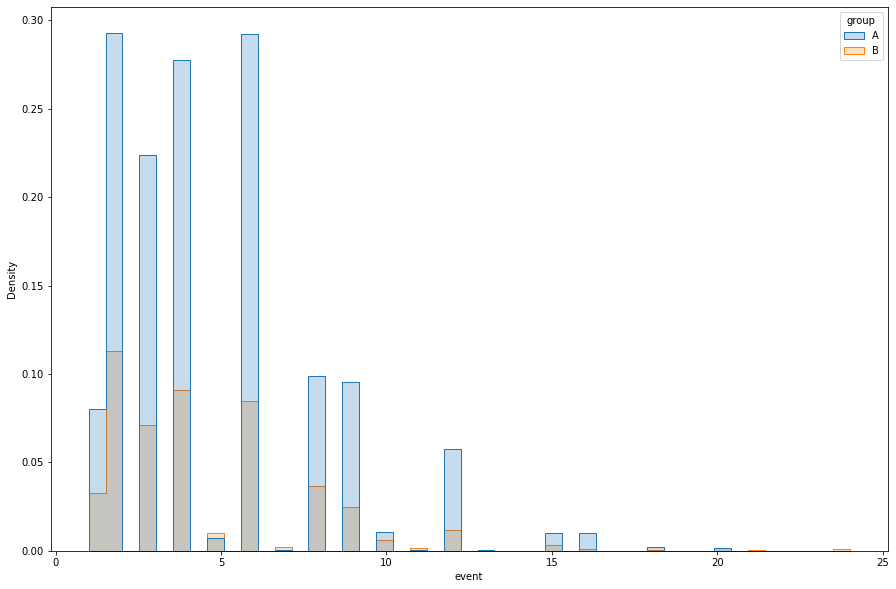

In [31]:
fig, ax_1 = plt.subplots(figsize=(15, 10))
sns.histplot(
    pivotTable, x="event", hue="group", stat="density", element="step", ax=ax_1)
plt.show()

#### Как число событий в выборках распределено по дням?

In [32]:
df_events_recommend

user_id            event_dt    event_name  details  event_date
0      894A2506B3A50D03 2020-12-07 00:05:57  product_page      NaN  2020-12-07
1      894A2506B3A50D03 2020-12-07 00:05:57         login      NaN  2020-12-07
2      8FC9D1BB3017BE66 2020-12-07 00:07:47      purchase     4.99  2020-12-07
3      8FC9D1BB3017BE66 2020-12-07 00:07:47         login      NaN  2020-12-07
4      8FC9D1BB3017BE66 2020-12-07 00:07:48  product_page      NaN  2020-12-07
...                 ...                 ...           ...      ...         ...
24693  BB3873E1AC6E7BC3 2020-12-29 23:38:29  product_page      NaN  2020-12-29
24694  75845C83258FBF73 2020-12-30 06:42:52  product_cart      NaN  2020-12-30
24695  75845C83258FBF73 2020-12-30 06:42:52         login      NaN  2020-12-30
24696  DD4352CDCF8C3D57 2020-12-30 12:42:56         login      NaN  2020-12-30
24697  DD4352CDCF8C3D57 2020-12-30 12:42:57  product_page      NaN  2020-12-30

[24698 rows x 5 columns]

In [33]:
df_temp = df_events_recommend.merge(df_participants[df_participants['ab_test'] == 'recommender_system_test'], on='user_id')
pivotTable_2 = df_temp[(df_temp["event_date"]>=pd.to_datetime('2020-12-07')) & (df_temp["event_date"]<=pd.to_datetime('2020-12-21'))].pivot_table(
    index=['group', 'event_date'],
    values='event_name',
    aggfunc=['count'],
    fill_value = 0
).reset_index()

pivotTable_2.columns=['group', 'date', 'count']

C:\Users\qdz91\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [34]:
pivotTable_2.head()

group        date  count
0     A  2020-12-07    331
1     A  2020-12-08    341
2     A  2020-12-09    385
3     A  2020-12-10    350
4     A  2020-12-11    374

C:\Users\qdz91\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


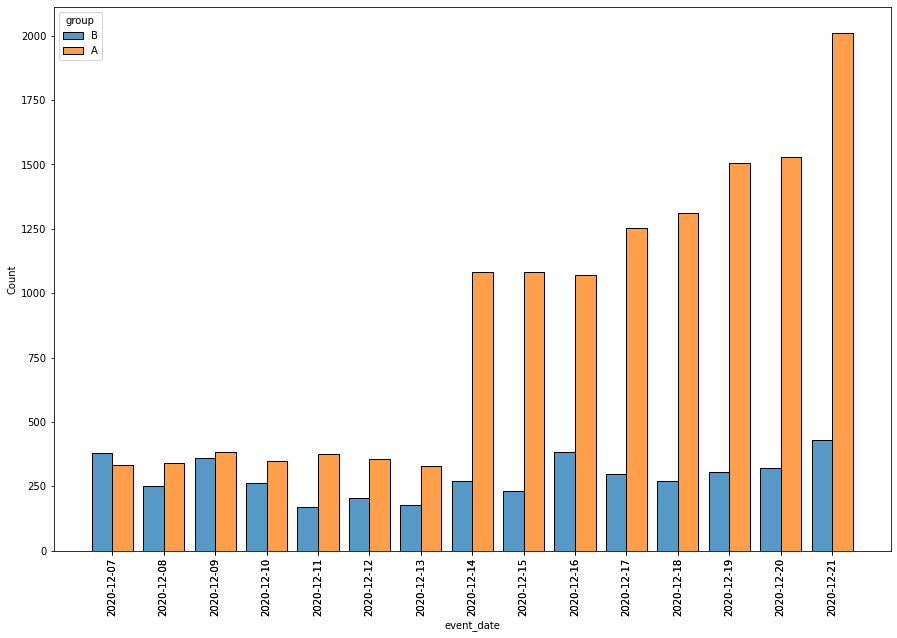

In [35]:
fig, ax_2 = plt.subplots(figsize=(15, 10))
sns.histplot(
    df_temp[(df_temp["event_date"]>=pd.to_datetime('2020-12-07')) & (df_temp["event_date"]<=pd.to_datetime('2020-12-21'))], x="event_date", multiple="dodge", hue="group", shrink=.8, ax=ax_2)

plt.xticks(rotation=90)
ax_2.set_xticks(pivotTable_2.date.tolist())
plt.show()

#### Как меняется конверсия в воронке в выборках на разных этапах?

In [36]:
df_events_temp = df_temp[(df_temp["event_date"]>=pd.to_datetime('2020-12-07')) & (df_temp["event_date"]<=pd.to_datetime('2020-12-21'))]

C:\Users\qdz91\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [37]:
df_events_temp.event_name.unique()

array(['product_page', 'login', 'purchase', 'product_cart'], dtype=object)

In [38]:
df_events_temp.head(15)

user_id            event_dt    event_name  details  event_date  \
0   894A2506B3A50D03 2020-12-07 00:05:57  product_page      NaN  2020-12-07   
1   894A2506B3A50D03 2020-12-07 00:05:57         login      NaN  2020-12-07   
2   894A2506B3A50D03 2020-12-08 17:56:16         login      NaN  2020-12-08   
3   894A2506B3A50D03 2020-12-08 17:56:17  product_page      NaN  2020-12-08   
4   894A2506B3A50D03 2020-12-10 22:02:24         login      NaN  2020-12-10   
5   894A2506B3A50D03 2020-12-10 22:02:26  product_page      NaN  2020-12-10   
6   8FC9D1BB3017BE66 2020-12-07 00:07:47      purchase     4.99  2020-12-07   
7   8FC9D1BB3017BE66 2020-12-07 00:07:47         login      NaN  2020-12-07   
8   8FC9D1BB3017BE66 2020-12-07 00:07:48  product_page      NaN  2020-12-07   
9   8FC9D1BB3017BE66 2020-12-07 00:07:49  product_cart      NaN  2020-12-07   
10  8FC9D1BB3017BE66 2020-12-08 02:44:25      purchase     4.99  2020-12-08   
11  8FC9D1BB3017BE66 2020-12-08 02:44:25         login      NaN  2020-12-08   
12  8FC9D1BB3017BE66 2020-12-08 02:44:26  product_cart      NaN  2020-12-08   
13  8FC9D1BB3017BE66 2020-12-08 02:44:31  product_page      NaN  2020-12-08   
14  4A55475E078F40DC 2020-12-07 00:14:01      purchase     9.99  2020-12-07   

   group                  ab_test  
0      B  recommender_system_test  
1      B  recommender_system_test  
2      B  recommender_system_test  
3      B  recommender_system_test  
4      B  recommender_system_test  
5      B  recommender_system_test  
6      B  recommender_system_test  
7      B  recommender_system_test  
8      B  recommender_system_test  
9      B  recommender_system_test  
10     B  recommender_system_test  
11     B  recommender_system_test  
12     B  recommender_system_test  
13     B  recommender_system_test  
14     A  recommender_system_test

In [39]:
df_events_funnel = df_events_temp.pivot_table(columns='group', index='event_name', values='user_id', aggfunc=lambda x: x.nunique())

df_events_funnel.columns = ['A', 'B']
df_events_funnel['range'] = [1, 3, 2, 4]
df_events_funnel['conv_A'] = None
df_events_funnel['conv_B'] = None
df_events_funnel = df_events_funnel.sort_values('range')[['A', 'B', 'conv_A', 'conv_B']]


df_events_funnel.loc['login', 'conv_A'] = df_events_funnel.loc['login', 'A']/df_events_funnel.loc['login', 'A']
df_events_funnel.loc['login','conv_B'] = df_events_funnel.loc['login', 'B']/df_events_funnel.loc['login', 'B']

for label_start, row_start in df_events_funnel.iterrows():
    df_events_funnel.loc[label_start, 'conv_A'] = round(row_start.A/df_events_temp[df_events_temp['group']=='A']['user_id'].nunique(), 2)
    df_events_funnel.loc[label_start, 'conv_B'] = round(row_start.B/df_events_temp[df_events_temp['group']=='B']['user_id'].nunique(), 2)
    
df_events_funnel    

A    B conv_A conv_B
event_name                           
login         2747  927    1.0    1.0
product_page  1780  523   0.65   0.56
product_cart   824  255    0.3   0.27
purchase       872  256   0.32   0.28

#### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

1. Неравномерность распределения групп;
2. Количество событий не равномерно распределены на пользователя, следовательно, нужно будет брать только уникальные события по пользователям;
3. Так же объём выборок может быть мал. Придется проверить мощность критерия и отвечает ли она заданной(не менее 80 %)

### Проведите оценку результатов A/B-тестирования:
    - Что можно сказать про результаты A/B-тестирования?
    - Проверьте статистическую разницу долей z-критерием

* H0 - Конверсия в шаг (product_page, product_cart, purchase) из login в группе A не отличается от конверсии в группе B
* H1 - Конверсии группы A и B отличаются

In [60]:
df_for_test

A    B conv_A conv_B     p_val
event_name                                     
product_page  1780  523   0.65   0.56  0.000005
product_cart   824  255    0.3   0.27  0.150342
purchase       872  256   0.32   0.28  0.018475

In [59]:
df_for_test = df_events_funnel.iloc[1:]
df_for_test['p_val'] = df_for_test.apply(lambda row: proportions_ztest((row.B, row.A), 
                                                      (df_events_funnel.loc['login', 'B'], df_events_funnel.loc['login', 'A']))[1], axis=1)

for label, row in df_for_test.iterrows():
    if row.p_val > alpha_cor:
        print(f'конверсия в {label} группы A={row.conv_A} и группы B={row.conv_B} значимо не отличаются. Мы не может отклонить нулевую гипотезу, так как {row.p_val} > {alpha_cor}')
    else:
        print(f'конверсия в {label} группы A={row.conv_A} и группы B={row.conv_B} значимо отличаются. Мы отклоняем нулевую гипотезу в пользу альтернативной, так как {row.p_val} > {alpha_cor}')
    print()

конверсия в product_page группы A=0.65 и группы B=0.56 значимо отличаются. Мы отклоняем нулевую гипотезу в пользу альтернативной, так как 5.08436808081463e-06 > 0.01

конверсия в product_cart группы A=0.3 и группы B=0.27 значимо не отличаются. Мы не может отклонить нулевую гипотезу, так как 0.1503421642219462 > 0.01

конверсия в purchase группы A=0.32 и группы B=0.28 значимо не отличаются. Мы не может отклонить нулевую гипотезу, так как 0.018474632659979635 > 0.01



C:\Users\qdz91\AppData\Local\Temp/ipykernel_18396/1331130019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_test['p_val'] = df_for_test.apply(lambda row: proportions_ztest((row.B, row.A),


### Вывод

На основе проведенных исследований можно сказать, что данный А/Б-тест не сделан в соответствии с ТЗ, пользователи попали в два параллельных теста, есть пользователи попавшие в обе группы(А и Б), есть несоответсвие с набором данных по ТЗ в том числе и датах сбора данных, так же присутствует существенный перекос в выборке и выборка достаточно мала(менее 6000 за две недели), что повлияло на мощность критерия. Следовательно есть два варианта решения данной проблемы:
* Либо увеличить выборку проведя повторный эксперимент и набор данных;
* Либо увеличить возможность ошибки первого рода до 0.1(10%), что может быть вполне уместно и сэкономит время и деньги бизнеса и компании.

По данным итогам аб-теста можно сказать, что есть существенная разница только в конверсии на просмотры карточки товара в пользу старой рекомендательной системы. Остальное не имеет значимых различий. Следовательно, менять рекомендательную систему не имеет смысла и не рекомендуется.